# Analysis of decision trees of the leading GBT model

In [1]:
import matplotlib.pyplot as plt
from dtreeviz import trees
from dtreeviz.models.spark_decision_tree import ShadowSparkTree
from pyspark.ml.tuning import CrossValidatorModel
from pyspark.sql import SparkSession
import matplotlib as mpl

In [2]:
# constants
sty = "seaborn"
mpl.style.use(sty)
fontsize = 11
fontfamily = "Arial"
out_path = "../../out/analysis/model/tree/"
figsize = (8,6)
tree_index = 0

In [3]:
appName = "GBT Tree Analysis"
spark = SparkSession\
    .builder\
    .appName(appName)\
    .master("local[2]")\
    .config("spark.driver.memory", "3g")\
    .getOrCreate()

22/03/07 14:58:15 WARN Utils: Your hostname, felix-Surface-Book resolves to a loopback address: 127.0.1.1; using 192.168.0.4 instead (on interface wlp3s0)
22/03/07 14:58:15 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/03/07 14:58:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Read the data and reproduce the data set

In [4]:
# read dataset
data_name = "batch_jobs_clean_03inst_1task_00015S_1F"
data_path = f"../../out/clean/{data_name}/*.csv.gz"
data = spark.read.csv(data_path, header=True, inferSchema=True)
# reproduce training set
seed = 61
fractions = {0: 0.50, 1: 0.50}
training = data.sampleBy(col="labels", fractions=fractions, seed=seed)
# stratified (50/25/25) split to have 50% of the data for training, 25 for validation (hyper
rest = data.subtract(training)
fractions = {0: 0.25, 1: 0.25}
validation = rest.sampleBy(col = "labels", fractions = fractions, seed = seed)
test = rest.subtract(validation)

In [5]:
#(data.count(), training.count(), test.count(), validation.count())

# load CV model and get the pipeline

In [6]:
model_name = "GBT5CV3parall_priorFeat_tune_maxDepth_Iter_Bins_03inst777Seed"
model_path = f"../../out/model/dump/final/{model_name}"
# load CV model and get the pipeline
cv_model = CrossValidatorModel.load(model_path)
pipeline = cv_model.bestModel
gbt_classifier = pipeline.stages[-1]
# the 20 tree ensemble
gbt_trees = gbt_classifier.trees
dt_high_weight = gbt_trees[tree_index]
some_tree = gbt_trees[1]

## transform the training data

In [7]:
# taken from GBTCVTaskFailBinPred.scala
columns = ["instance_num",  # number of instances for the task
           "task_type",  # values 1-12, meaning unknown (ordinal categ. feature)
           "plan_cpu",  # number of cpus needed by the task, 100 is 1 core
           "plan_mem",  # normalized memory size, [0, 100]
           # from batch instances
           "seq_no",
           "labels",
           # custom fields I added in trace.py
           "map_reduce",
           # whether this task is a map "m" or reduce "r" operation (nominal categ. feature) -> 1hot encode
           "sched_intv",  # the schedule interval (in ?) if this value is set, its a recurring job (batch job)
           "job_exec",  # the number of execution of this task
           "logical_job_name"]
# get only raw features for transform
training_raw = training.select(columns)
# transform the test data
features = pipeline.stages[5].getInputCols()
# we go for "failed" instances
target = "labels"
target_name = "failed"
training_transf = pipeline.transform(training_raw)\
    .toPandas()[features + [target]]

22/03/07 14:58:37 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
22/03/07 14:58:38 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/03/07 14:58:38 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


In [8]:
training_transf

,instance_num_imp,task_type_imp,plan_mem_imp,seq_no_imp,sched_intv_imp,job_exec_imp,map_reduce_idx_one_hot,logical_job_name_idx_one_hot,plan_cpu_vec_scaled,labels
0,1,1,0.59,1,1,47351,(0.0),"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[0.09547738693467338],1
1,80,1,0.30,1,3,121196,(1.0),"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[0.09547738693467338],0
2,3438,1,0.30,1,1,17975,(1.0),"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[0.09547738693467338],0
3,5747,1,0.30,1,3,8504,(1.0),"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[0.09547738693467338],0
4,37881,1,0.68,1,1,85065,(1.0),"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[0.04522613065326633],0
...,...,...,...,...,...,...,...,...,...,...
372376,351,1,0.39,1,311,1088,(0.0),"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[0.04522613065326633],0
372377,53667,1,0.30,1,6,52994,(1.0),"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[0.09547738693467338],1
372378,7458,8,0.08,1,8,329,(1.0),"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[0.19597989949748745],1
372379,14782,1,0.49,1,8,76705,(1.0),"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[0.09547738693467338],1


# plot decision tree regression model

In [9]:
# define the shadow tree for the decision tree regressor
spark_dtree = ShadowSparkTree(
    tree_model=dt_high_weight,
    x_data=training_transf[features],
    y_data=training_transf[target],
    feature_names=features,
    target_name=target_name
)

In [10]:
# TODO: fix this
#trees.dtreeviz(
#    tree_model=spark_dtree,
#    tree_index=tree_index,
#    show_just_path=True
#)

## Visualize the number of data samples from each leaf
Interpreting leaf samples can help us to see how the data is spread over the tree:
- if we have a leaf with many samples and a good impurity, it means that we can be pretty confident
on its prediction.
- if we have a leaf with few samples and a good impurity, we cannot be very confident on its predicion and
it could be a sign of overfitting.
- by visualizing leaf samples, we can easily discover important leaves . Using describe_node_sample() function we
can take all its samples and discover common patterns between leaf samples.
- if the tree contains a lot of leaves and we want a general overview about leaves samples, we can use the
parameter display_type='hist' to display the histogram of leaf samples.

There is the option to filter the leaves with samples between 'min_samples' and 'max_samples'. This is helpful
especially when you want to investigate leaves with number of samples from a specific range.

Note : If the x_data and y_data are the datasets used to trained the model, then we will investigate the tree model
as it was trained. We can give other x_data and y_data datasets, ex. validation dataset, to see how the new data is
spread over the tree.


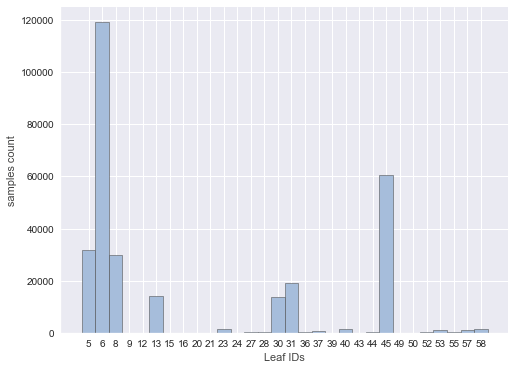

In [18]:
plot_name = "viz_leaf_samples"
trees.viz_leaf_samples(
    tree_model=spark_dtree,
    tree_index=tree_index,
    display_type="plot",
    figsize=figsize,
    grid=True,
    #min_samples=400,
    fontsize=fontsize,
    fontname=fontfamily
)

#plt.xticks(ticks=range(1,61,2), labels=range(1,61,2))
#plt.ylabel("Samples count")
plt.xlabel("Leaf IDs")
path = out_path + plot_name + ".pdf"
#plt.title("leaf sample distribution")
plt.savefig(path, format="pdf")

## Visualize leaves criterion
- This information shows the leaf performance/confidence for its predictions, namely how pure or
    impure are the samples from each leaf
- it shows the information gain per leaf
- Each leaf performance, in the end, will determine the general tree performance
- This visualisation can be used together with viz_leaf_samples() for a better leaf interpretation. For example,
    a leaf with good confidence, but few samples, can be a sign of overfitting. The best scenario would be to have a
    leaf with good confidence and also a lot of samples.

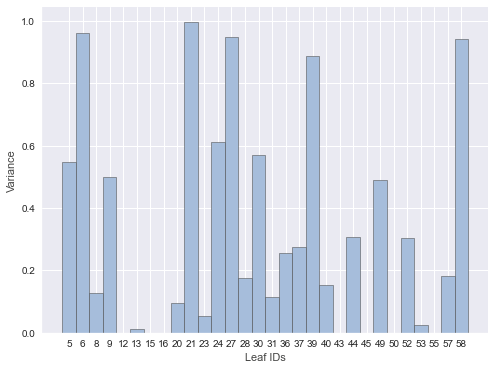

In [15]:
plot_name="viz_leaf_criterion"
trees.viz_leaf_criterion(
    tree_model=spark_dtree,
    tree_index=tree_index,
    figsize=figsize,
    display_type="plot",
    grid=True,
    fontsize=fontsize,
    fontname=fontfamily
)

# leaf 6 is good
# those nodes with no samples have negative variance
plt.ylabel("Variance")
#ticks = [5,6,8,13,23,30,31,36,37,40,45,52,53,57,58]
#plt.xticks(ticks=ticks, labels=ticks)
plt.xlabel("Leaf IDs")
path = out_path + plot_name + ".pdf"
#plt.title("Impurity (variance) per leaf of the tree")
plt.savefig(path, format="pdf")

## Visualize leaf target distribution for regression decision trees


In [13]:
plot_name = "viz_leaf_target"
trees.viz_leaf_target(
    tree_model=spark_dtree,
    tree_index=tree_index,
    figsize=figsize,
    grid=True,
    feature_names=features,
    precision=3
)
path = out_path + plot_name + ".pdf"
#plt.title("leaf target distribution")
plt.savefig(path, format="pdf")

KeyboardInterrupt: 

### explain the prediction path
- Prediction path interpretation for a data instance

In [ ]:
row = 3
x = training_transf[features].iloc[row]
Y = training_transf[target]
y = training_transf[target].iloc[row]
x, y

In [ ]:
print(trees.explain_prediction_path(spark_dtree, x = x, y_data= Y, explanation_type="plain_english", tree_index=0))

In [ ]:
# TODO: fix this
#trees.dtreeviz(spark_dtree, X=x)